In [239]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
import xgboost as xgb
import gc
from sklearn.metrics import mean_absolute_error

In [240]:
def lgb_modelfit_nocv(params, dtrain, dvalid,y_train,y_valid, objective='regression', metrics='mae',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=300, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 10,
        'verbose': 30,
        'metric':metrics
    }

    lgb_params.update(params)
    ################################################################################################################
    
    
    
    
    #################################################################################################################

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain, y_train)
    xgvalid = lgb.Dataset(dvalid, y_valid)

    evals_results = {}
    ########################################################################################################################
    
    from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
    from hyperopt.fmin import fmin
    from sklearn.metrics import roc_auc_score
    # objective function to optimize; loss is auroc
    

    def objective(params):

        bst = lgb.train(params, 
                         xgtrain, 
                         valid_sets= [xgtrain,xgvalid],  
                         num_boost_round=5000,
                         early_stopping_rounds=50,
                         verbose_eval=200)
    
        pred = bst.predict(dvalid)
        mae= mean_absolute_error(y_valid, pred)

        del bst, pred
        gc.collect()
        print('**********************************************************')
        print(params)
        print("SCORE ............. : ",mae)
        print('**********************************************************')
        
        return { 'loss': mae, 'status': STATUS_OK }

    space = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric':'mae',
            'learning_rate': 0.01,
            'num_leaves': hp.choice('num_leaves', np.arange(15, 1000,50, dtype=int)),
            'max_depth': hp.choice('max_depth', np.arange(6, 15, dtype=int)),
            #'min_child_samples': hp.choice('min_child_samples', np.arange(100, 500,50, dtype=int)),
            #'max_bin': hp.choice('max_bin', np.arange(100, 5000,50, dtype=int)),
            #"drop_rate": 0.2,
            'subsample': 0.9,
            'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.1),
            #'min_child_weight': hp.quniform('min_child_weight', 1, 100, 1),  # Minimum sum of instance weight(hessian) needed in a child(leaf)
            'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
            'nthread': 10,
            'verbose': 0,
            #'scale_pos_weight': hp.choice('scale_pos_weight', np.arange(100, 500,10, dtype=int)),
            }

    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=30, # WARNING: increase number of evaluations (it's small for the sake of example)
        trials=trials
        )

    # best hyperparameters
    print("\n\n\n The best hyperparameters:")
    print(best)
    #########################################################################################################################
    return bst, best

In [241]:
print('loading train data...')
train_df = pd.read_csv("./boites_medicaments_train.csv",sep=';')
train_df['prix']=np.log(train_df['prix'])
y=train_df['prix']
print('loading test data...')
test_df = pd.read_csv("./boites_medicaments_test.csv",sep=';')
len_train = len(train_df)
len_test = len(test_df)
train_df=train_df.append(test_df)
del train_df['prix'],train_df['id'],train_df['libelle']
del test_df
gc.collect()

loading train data...
loading test data...


9764

In [242]:
train_df.head()

,agrement col,date amm annee,date declar annee,etat commerc,forme pharma,libelle_ampoule,libelle_capsule,libelle_comprime,libelle_film,libelle_flacon,...,nb_seringue,nb_stylo,nb_tube,statut,statut admin,substances,titulaires,tx rembours,type proc,voies admin
0,oui,2014,2014,Déclaration de commercialisation,comprimé pelliculé,0,0,1,0,0,...,0,0,0,Présentation active,Autorisation active,DÉSOGESTREL,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),65%,Procédure décentralisée,orale
1,oui,2009,2013,Déclaration de commercialisation,comprimé à croquer,0,0,1,0,0,...,0,0,0,Présentation active,Autorisation active,"MONTÉLUKAST ACIDE, MONTÉLUKAST SODIQUE",TEVA SANTE,65%,Procédure de reconnaissance mutuelle,orale
2,oui,1996,2000,Déclaration de commercialisation,gélule à libération prolongée,0,0,0,0,0,...,0,0,0,Présentation active,Autorisation active,CHLORHYDRATE DE DILTIAZEM,MYLAN SAS,65%,Procédure nationale,orale
3,oui,2004,2005,Déclaration de commercialisation,granulés à libération prolongée,0,0,0,0,0,...,0,0,0,Présentation active,Autorisation active,"ACIDE VALPROÏQUE, VALPROATE DE SODIUM",SANOFI AVENTIS FRANCE,65%,Procédure nationale,orale
4,non,2010,2015,Déclaration d'arrêt de commercialisation,comprimé pelliculé,0,0,1,0,0,...,0,0,0,Présentation active,Autorisation active,LÉTROZOLE,TEVA SANTE,100%,Procédure nationale,orale


In [243]:
def feature_df(df):
    Features={}
    Features['Num']=[]
    Features['Cat']=[]
    for c in df.columns: 
        if df[c].dtype=='O':
            Features['Cat'].append(c)
        else:
            Features['Num'].append(c)
    return Features
Fe = feature_df(train_df)

In [244]:
y.describe()

count    8564.000000
mean        2.279071
std         1.271988
min        -0.510826
25%         1.371181
50%         2.071913
75%         3.002211
max         6.898099
Name: prix, dtype: float64

In [245]:
txt_Fe=['forme pharma','titulaires','substances']
Cat_Fe =list(set(Fe['Cat'])-set(txt_Fe))

In [246]:
Cat_Fe

['statut admin',
 'tx rembours',
 'type proc',
 'agrement col',
 'voies admin',
 'statut',
 'etat commerc']

In [247]:
train_df['tx rembours'].value_counts()

65%     10269
30%       910
15%       593
100%      462
0%          1
Name: tx rembours, dtype: int64

In [248]:
train_df.head()

,agrement col,date amm annee,date declar annee,etat commerc,forme pharma,libelle_ampoule,libelle_capsule,libelle_comprime,libelle_film,libelle_flacon,...,nb_seringue,nb_stylo,nb_tube,statut,statut admin,substances,titulaires,tx rembours,type proc,voies admin
0,oui,2014,2014,Déclaration de commercialisation,comprimé pelliculé,0,0,1,0,0,...,0,0,0,Présentation active,Autorisation active,DÉSOGESTREL,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),65%,Procédure décentralisée,orale
1,oui,2009,2013,Déclaration de commercialisation,comprimé à croquer,0,0,1,0,0,...,0,0,0,Présentation active,Autorisation active,"MONTÉLUKAST ACIDE, MONTÉLUKAST SODIQUE",TEVA SANTE,65%,Procédure de reconnaissance mutuelle,orale
2,oui,1996,2000,Déclaration de commercialisation,gélule à libération prolongée,0,0,0,0,0,...,0,0,0,Présentation active,Autorisation active,CHLORHYDRATE DE DILTIAZEM,MYLAN SAS,65%,Procédure nationale,orale
3,oui,2004,2005,Déclaration de commercialisation,granulés à libération prolongée,0,0,0,0,0,...,0,0,0,Présentation active,Autorisation active,"ACIDE VALPROÏQUE, VALPROATE DE SODIUM",SANOFI AVENTIS FRANCE,65%,Procédure nationale,orale
4,non,2010,2015,Déclaration d'arrêt de commercialisation,comprimé pelliculé,0,0,1,0,0,...,0,0,0,Présentation active,Autorisation active,LÉTROZOLE,TEVA SANTE,100%,Procédure nationale,orale


In [249]:
print("Feature Engineering")
train_df['diff_ann']=train_df['date declar annee'] - train_df['date amm annee']
print("label encoding....")
from sklearn.preprocessing import LabelEncoder
train_df[Cat_Fe]=train_df[Cat_Fe].apply(LabelEncoder().fit_transform)
print("dealing with txt Features....")
def tokenizeL(text):
    return [ w for w in str(text).split(",")]
for i in txt_Fe:
    train_df[i]=train_df[i].apply(lambda x:x.lower())
    train_df[i]=train_df[i].apply(lambda x:str(x).replace(',', " "))

Feature Engineering
label encoding....
dealing with txt Features....


In [250]:
train_df.head()

,agrement col,date amm annee,date declar annee,etat commerc,forme pharma,libelle_ampoule,libelle_capsule,libelle_comprime,libelle_film,libelle_flacon,...,nb_stylo,nb_tube,statut,statut admin,substances,titulaires,tx rembours,type proc,voies admin,diff_ann
0,1,2014,2014,2,comprimé pelliculé,0,0,1,0,0,...,0,0,1,1,désogestrel,majorelle luxembourg soparfi (luxembourg),4,3,66,0
1,1,2009,2013,2,comprimé à croquer,0,0,1,0,0,...,0,0,1,1,montélukast acide montélukast sodique,teva sante,4,2,66,4
2,1,1996,2000,2,gélule à libération prolongée,0,0,0,0,0,...,0,0,1,1,chlorhydrate de diltiazem,mylan sas,4,4,66,4
3,1,2004,2005,2,granulés à libération prolongée,0,0,0,0,0,...,0,0,1,1,acide valproïque valproate de sodium,sanofi aventis france,4,4,66,1
4,0,2010,2015,1,comprimé pelliculé,0,0,1,0,0,...,0,0,1,1,létrozole,teva sante,1,4,66,5


In [251]:
#train_df['txt']=train_df.substances.astype(str)+' '\
#                +train_df.titulaires.astype(str)+' '\
#                +train_df['forme pharma'].astype(str)


In [252]:
train_df.fillna(-999,inplace=True)
train_df.head()

,agrement col,date amm annee,date declar annee,etat commerc,forme pharma,libelle_ampoule,libelle_capsule,libelle_comprime,libelle_film,libelle_flacon,...,nb_stylo,nb_tube,statut,statut admin,substances,titulaires,tx rembours,type proc,voies admin,diff_ann
0,1,2014,2014,2,comprimé pelliculé,0,0,1,0,0,...,0,0,1,1,désogestrel,majorelle luxembourg soparfi (luxembourg),4,3,66,0
1,1,2009,2013,2,comprimé à croquer,0,0,1,0,0,...,0,0,1,1,montélukast acide montélukast sodique,teva sante,4,2,66,4
2,1,1996,2000,2,gélule à libération prolongée,0,0,0,0,0,...,0,0,1,1,chlorhydrate de diltiazem,mylan sas,4,4,66,4
3,1,2004,2005,2,granulés à libération prolongée,0,0,0,0,0,...,0,0,1,1,acide valproïque valproate de sodium,sanofi aventis france,4,4,66,1
4,0,2010,2015,1,comprimé pelliculé,0,0,1,0,0,...,0,0,1,1,létrozole,teva sante,1,4,66,5


In [253]:
txt_Fe

['forme pharma', 'titulaires', 'substances']

In [254]:
# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 
stopWords = stopwords.words('french')
tfidf_para = {
    "stop_words": stopWords ,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.7,
    "smooth_idf":False
}

def get_col(col_name): return lambda x: x[col_name]
vectorizer = FeatureUnion([
        ('forme pharma',TfidfVectorizer(
            ngram_range=(1, 1),
            #max_features=1500,
            **tfidf_para,
            preprocessor=get_col('forme pharma'))),
        ('substances',TfidfVectorizer(
            ngram_range=(1, 1),
            #max_features=1500,
            **tfidf_para,
            preprocessor=get_col('substances'))),
    ('titulaires',TfidfVectorizer(
            ngram_range=(1, 1),
            #max_features=1500,
            **tfidf_para,
            preprocessor=get_col('substances'))),

    ])
    
start_vect=time.time()

#Fit my vectorizer on the entire dataset instead of the training rows
#Score improved by .0001
vectorizer.fit(train_df.to_dict('records'))

ready_df = vectorizer.transform(train_df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
train_df.drop(txt_Fe,axis=1,inplace=True)
from sklearn.linear_model import Ridge
from math import sqrt
from sklearn.cross_validation import KFold
NFOLDS = 5
SEED = 42
from sklearn.metrics import mean_squared_error

class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
kf = KFold(len_train, n_folds=NFOLDS, shuffle=True, random_state=SEED)

import numpy.random as nprnd
np.random.seed(10)
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((len_train,))
    oof_test = np.zeros((len_test,))
    oof_test_skf = np.empty((NFOLDS, len_test))
    cols=nprnd.randint(x_train.shape[1], size= int(x_train.shape[1]*0.7))
    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index].tocsc()[:,cols]
        y_tr = y[train_index]
        x_te = x_train[test_index].tocsc()[:,cols]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test.tocsc()[:,cols]
)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
for i in range(1,100) :
    #alpha=10*i
    ridge_params = {'alpha':1, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                    'max_iter':None, 'tol':0.001, 'solver':'sag', 'random_state':i}

    #Ridge oof method from Faron's kernel
    #I was using this to analyze my vectorization, but figured it would be interesting to add the results back into the dataset
    #It doesn't really add much to the score, but it does help lightgbm converge faster
    ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
    ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:len_train], y, ready_df[len_train:])

    rms = sqrt(mean_squared_error(y, ridge_oof_train))
    print('Ridge OOF RMSE: {}'.format(rms))

    print("Modeling Stage")

    ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])

    train_df['ridge_preds_'+str(i)] = ridge_preds



















X = hstack([csr_matrix(train_df[:len_train].values),ready_df[:len_train]]) # Sparse Matrix
X_test = hstack([csr_matrix(train_df[len_train:].values),ready_df[len_train:]])
tfvocab = train_df.columns.tolist() + tfvocab


Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.8113409975254201
Modeling Stage

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.8270310252772609
Modeling Stage

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.8151237150662947
Modeling Stage

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.7815941864591717
Modeling Stage

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.8028619668486472
Modeling Stage

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.8199628118175869
Modeling Stage

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.85324356303171
Modeling Stage

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.7859224347663536
Modeling Stage

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.7968548556604091
Modeling Stage

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.8136300133427042
Modeling Stage

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.8311423220313519
Modeling Stage

Fold 0

Fol

In [255]:
X.shape

(8564, 3133)

X=data[:len_train]
X_test=data[len_train:]
X_test.shape

In [256]:
X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.20, random_state=23)

In [257]:
bst={'boosting_type': 'gbdt', 'colsample_bytree': 0.7,
     'learning_rate': 0.015, 'max_depth': 12, 'metric': 'mape',
     'min_split_gain': 0, 'nthread': 10, 'num_leaves': 450, 
     'objective': 'regression', 'subsample': 0.85,
     'subsample_freq': 1, 'verbose': 0}

In [258]:
X.shape

(8564, 3133)

/home/rpyamer/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[200]	train's mape: 0.125434	valid's mape: 0.183604
[400]	train's mape: 0.0949096	valid's mape: 0.16716
[600]	train's mape: 0.08282	valid's mape: 0.16172
[800]	train's mape: 0.0740029	valid's mape: 0.158946
[1000]	train's mape: 0.0677234	valid's mape: 0.157525
[1200]	train's mape: 0.0626502	valid's mape: 0.156489
[1400]	train's mape: 0.0590473	valid's mape: 0.155895
[1600]	train's mape: 0.0559481	valid's mape: 0.155372
[1800]	train's mape: 0.0532026	valid's mape: 0.155154
[2000]	train's mape: 0.0509931	valid's mape: 0.154907
[2200]	train's mape: 0.0488734	valid's mape: 0.15475
[2400]	train's mape: 0.0471404	valid's mape: 0.154606
[2600]	train's mape: 0.0458836	valid's mape: 0.154519
[2800]	train's mape: 0.0446827	valid's mape: 0.15436
[3000]	train's mape: 0.043567	valid's mape: 0.154272
[3200]	train's mape: 0.0424924	valid's mape: 0.154067
Early stopping, best iteration is:
[3174]	train's mape: 0.0426495	valid's mape: 0.154

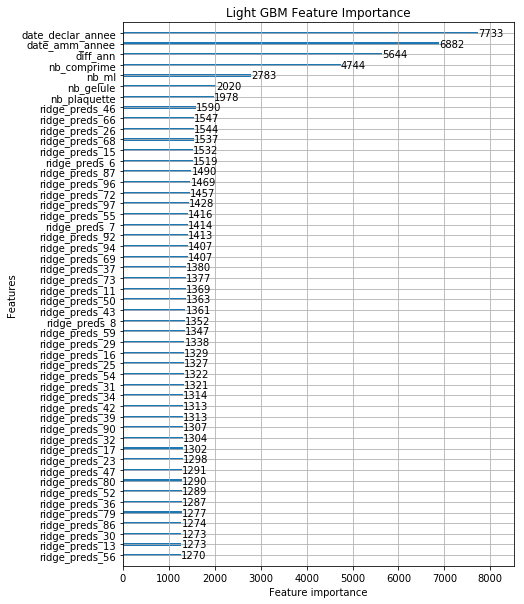

In [259]:
from sklearn.cross_validation import KFold

lgtrain = lgb.Dataset(X_train, y_train,feature_name=tfvocab,categorical_feature=Cat_Fe)
lgvalid = lgb.Dataset(X_valid, y_valid,feature_name=tfvocab,categorical_feature=Cat_Fe)

lgb_clf = lgb.train(
    bst,
    lgtrain,
    num_boost_round=16000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=200,
    verbose_eval=200,
    categorical_feature=Cat_Fe
)
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

In [260]:
print("Model pred ...")
lgpred = np.exp(lgb_clf.predict(X_test))

Model pred ...


/home/rpyamer/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [261]:
sub=pd.DataFrame()
sub['id']=range(1,X_test.shape[0]+1)
sub['prix']=lgpred

In [262]:
sub.to_csv('yes.csv',sep=';',index=False)